## ```NoteBook Focus```
---
1. Figure out input and default variables.
    - Setting some input to a default setting will make the user interface less crowded.
2. Choose and save models that will be used for voting in the app.
    - Each model used will have a vote on whether the offender is recieving a prison sentence vs a non prison sentence. The class that recieves the most votes is the class predicted.
3. Build a function that returns the highest voted class and possibly the probability of our prediction.

## ```Imports```
---

In [92]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from classifiers_copy import classify

import pickle

import warnings
warnings.filterwarnings('ignore')

## ```Choosen Voting Models and Saving Them```
---

In [2]:
drugs = pd.read_csv('../Claire/data/drugs_2020_simply_imputed.csv')
drugs.head(2)

,accgdln,age,altdum,amttotal,casetype,citwhere,combdrg2,crimhist,disposit,district,...,typemony,typeoths,unit1,mwgt1,wgt1,xcrhissr,xfolsor,xmaxsor,xminsor,sentrnge
0,1.0,20.0,0,0,1.0,211.0,6.0,1.0,1,43,...,1.0,0,1.0,6.356099e+07,85104.433315,1.0,17.0,30.0,24.0,8.0
1,1.0,64.0,0,0,1.0,211.0,1.0,1.0,1,51,...,1.0,0,1.0,1.193400e+06,5967.000000,3.0,27.0,108.0,87.0,0.0


1    16075
0      754
Name: prisdum, dtype: int64
1    16075
0    16075
Name: prisdum, dtype: int64
train acc: 0.8225727616085314
test acc: 0.826023846552618


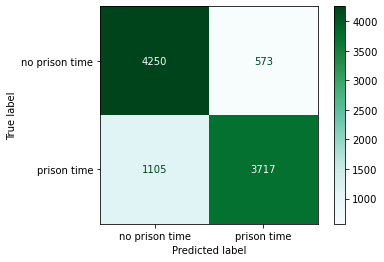

In [82]:
# set up X/y
X = drugs[[ 
            'accgdln', 'casetype', 'combdrg2', 'crimhist', 'disposit', 
            'district', 'drugmin', 'dsplea', 'intdum', 'methmin', 'mweight','nodrug',
            'offguide', 'quarter', 'reas1', 'reas2', 'reas3', 'numdepen',
            'sources', 'statmax', 'statmin'
         ]]

y = drugs['prisdum']
print(y.value_counts())

# # boost minor class value count
smo = SMOTE(random_state=42)
X_smo, y_smo = smo.fit_resample(X,y)
print(y_smo.value_counts())

# set train/test split
X_train, X_test, y_train, y_test = train_test_split(X_smo,y_smo,random_state=42, train_size=0.7, stratify=y_smo)

# scale data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test) 

# instantiate, train, evaluate
lr = LogisticRegression()
lr.fit(X_train_ss,y_train)

# evaluate
print(f"train acc: {lr.score(X_train_ss,y_train)}")
print(f"test acc: {lr.score(X_test_ss,y_test)}")
    
plot_confusion_matrix(lr, X_test_ss, y_test, cmap='BuGn', display_labels=['no prison time', 'prison time'])

In [63]:
classify(X_train_ss, X_test_ss, y_train, y_test)

,Train Acc,Test Acc,Acc-diff,Train-F1,Test-F1,F1-diff,Train-Pres,Test-Pres,Pres-diff,Train_Recall,Test-Recall,Recall_diff
knn,0.942857,0.911457,0.031400,0.941889,0.909572,0.032317,0.958169,0.929251,0.028917,0.926153,0.890709,0.035444
logreg,0.821995,0.824054,0.002059,0.810250,0.812838,0.002588,0.867532,0.868080,0.000548,0.760064,0.764206,0.004142
dt,0.998978,0.957076,0.041902,0.998977,0.956749,0.042228,0.999733,0.964000,0.035733,0.998223,0.949606,0.048617
bag,0.997023,0.966822,0.030201,0.997020,0.966562,0.030458,0.998130,0.974094,0.024035,0.995912,0.959146,0.036767
bag_knn,0.945123,0.913116,0.032008,0.944181,0.911097,0.033084,0.960725,0.932667,0.028058,0.928197,0.890502,0.037695
bag_log,0.821462,0.824054,0.002592,0.809592,0.812590,0.002998,0.867296,0.869124,0.001827,0.759086,0.762961,0.003875
rf,0.998978,0.978434,0.020544,0.998978,0.978446,0.020532,0.999200,0.977838,0.021362,0.998756,0.979054,0.019702
et,0.998978,0.975739,0.023239,0.998977,0.975615,0.023362,0.999733,0.980519,0.019214,0.998223,0.970759,0.027464
ada,0.934770,0.937377,0.002607,0.934417,0.937031,0.002613,0.939538,0.942138,0.002600,0.929352,0.931978,0.002626
gboost,0.956676,0.957802,0.001126,0.956684,0.957609,0.000925,0.956557,0.961917,0.005360,0.956812,0.953339,0.003473


In [100]:
with open('../carlos/app_models/logreg.pkl', mode = 'wb') as pickle_out:
    pickle_out = pickle.dump(lr, pickle_out)

In [102]:
with open('../carlos/app_models/logreg.pkl', mode='rb') as pickle_in:
    lr = pickle.load(pickle_in)

In [103]:
lr.predict(X_test_ss)

array([0, 1, 0, ..., 0, 1, 0])

In [105]:
X_test_ss[0]

array([ 3.40354996,  2.67413092, -0.41293824,  0.48399128, -0.10890092,
        1.02059964, -0.19795372, -0.41227324, -0.02667319, -0.01206129,
        0.06193575, -0.43545595, -2.34813717, -0.15888882, -0.33543118,
       -0.34285816, -0.35145556,  0.11726151,  3.41090935, -0.72179848,
       -0.22334967])

In [107]:
lr.predict([X_test_ss[0]])

array([0])

In [112]:
lr.predict_proba([X_test_ss[0]])

array([[0.98446295, 0.01553705]])

In [91]:
knn = KNeighborsClassifier()
knn.fit(X_train_ss,y_train)

with open('../carlos/app_models/knn.pkl', mode = 'wb') as pickle_out:
    pickle_out = pickle.dump(knn, pickle_out)

array([1, 1, 1, ..., 1, 1, 1])

In [93]:
dt = DecisionTreeClassifier()
dt.fit(X_train_ss,y_train)

with open('../carlos/app_models/dt.pkl', mode = 'wb') as pickle_out:
    pickle_out = pickle.dump(dt, pickle_out)

In [108]:
dt.predict([X_test_ss[0]])

array([0])

In [115]:
dt.predict_proba([X_test_ss[0]])[0][0]

0.9285714285714286

In [94]:
rf = RandomForestClassifier()
rf.fit(X_train_ss,y_train)

with open('../carlos/app_models/rf.pkl', mode = 'wb') as pickle_out:
    pickle_out = pickle.dump(rf, pickle_out)

In [95]:
bag = BaggingClassifier()
bag.fit(X_train_ss,y_train)

with open('../carlos/app_models/bag.pkl', mode = 'wb') as pickle_out:
    pickle_out = pickle.dump(bag, pickle_out)

In [96]:
et = ExtraTreesClassifier()
et.fit(X_train_ss,y_train)

with open('../carlos/app_models/et.pkl', mode = 'wb') as pickle_out:
    pickle_out = pickle.dump(et, pickle_out)

## ```Function that takes all model votes and outputs the classification```
---

In [98]:
model_list = [knn, 'dt', 'et', 'rf', 'bag']

for i in model_list:
    print(i)

KNeighborsClassifier()
dt
et
rf
bag


In [111]:
model_list = [knn, dt, et, rf, bag]
vote_1 = 0
for model in model_list:
    pred = model.predict(X_test_ss)
    if pred==1:
        vote_1+=1
    else:
        continue

vote_1

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()